# Daria Bromot (FS500047)

## OKCupid EDA

In [242]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from bs4 import BeautifulSoup
from scipy.sparse import csr_matrix, hstack
import catboost

import pandas as pd
import numpy as np
import scipy.stats as stats
import nltk
from textblob import TextBlob
from wordcloud import WordCloud

import warnings
warnings.filterwarnings('ignore')

## Part 1. Visualizing new dataframe

In [243]:
data = pd.read_csv("profiles.csv.zip")
data.head()

,age,body_type,diet,drinks,drugs,education,essay0,essay1,essay2,essay3,...,location,offspring,orientation,pets,religion,sex,sign,smokes,speaks,status
0,22,a little extra,strictly anything,socially,never,working on college/university,about me:<br />\n<br />\ni would love to think...,currently working as an international agent fo...,making people laugh.<br />\nranting about a go...,"the way i look. i am a six foot half asian, ha...",...,"south san francisco, california","doesn&rsquo;t have kids, but might want them",straight,likes dogs and likes cats,agnosticism and very serious about it,m,gemini,sometimes,english,single
1,35,average,mostly other,often,sometimes,working on space camp,i am a chef: this is what that means.<br />\n1...,dedicating everyday to being an unbelievable b...,being silly. having ridiculous amonts of fun w...,NaN,...,"oakland, california","doesn&rsquo;t have kids, but might want them",straight,likes dogs and likes cats,agnosticism but not too serious about it,m,cancer,no,"english (fluently), spanish (poorly), french (...",single
2,38,thin,anything,socially,NaN,graduated from masters program,"i'm not ashamed of much, but writing public te...","i make nerdy software for musicians, artists, ...",improvising in different contexts. alternating...,my large jaw and large glasses are the physica...,...,"san francisco, california",NaN,straight,has cats,NaN,m,pisces but it doesn&rsquo;t matter,no,"english, french, c++",available
3,23,thin,vegetarian,socially,NaN,working on college/university,i work in a library and go to school. . .,reading things written by old dead people,playing synthesizers and organizing books acco...,socially awkward but i do my best,...,"berkeley, california",doesn&rsquo;t want kids,straight,likes cats,NaN,m,pisces,no,"english, german (poorly)",single
4,29,athletic,NaN,socially,never,graduated from college/university,hey how's it going? currently vague on the pro...,work work work work + play,creating imagery to look at:<br />\nhttp://bag...,i smile a lot and my inquisitive nature,...,"san francisco, california",NaN,straight,likes dogs and likes cats,NaN,m,aquarius,no,english,single


## Part 2. Primary feature analysis

In [244]:
data['diet'].unique()

array(['strictly anything', 'mostly other', 'anything', 'vegetarian', nan,
       'mostly anything', 'mostly vegetarian', 'strictly vegan',
       'strictly vegetarian', 'mostly vegan', 'strictly other',
       'mostly halal', 'other', 'vegan', 'mostly kosher',
       'strictly halal', 'halal', 'strictly kosher', 'kosher'],
      dtype=object)

So far, everything is simple - gastronomic preferences are given by the category and "how strict the diet is" - `<strictly|normal|mostly>`. Break the diet into 2 columns and fill in the gaps with fashion

In [245]:
def diet_transformer(x):
    if type(x) != list:
        return [None, None]
    if len(x) == 1:
        x.append('default')
        return x
    else:
        return x[::-1]
    
spltd = data['diet'].str.split(' ', 2).transform(diet_transformer)
spltd = pd.DataFrame(spltd.tolist(), columns=['diet_kind', 'diet_strenght'])
data['diet_kind'] = spltd['diet_kind'].fillna(spltd['diet_kind'].mode().values[0])
data['diet_strenght'] = spltd['diet_strenght'].fillna(spltd['diet_strenght'].mode().values[0])
data['diet_kind'].unique(), data['diet_strenght'].unique()

(array(['anything', 'other', 'vegetarian', 'vegan', 'halal', 'kosher'],
       dtype=object),
 array(['strictly', 'mostly', 'default'], dtype=object))

In [246]:
data['education'].unique()

array(['working on college/university', 'working on space camp',
       'graduated from masters program',
       'graduated from college/university', 'working on two-year college',
       nan, 'graduated from high school', 'working on masters program',
       'graduated from space camp', 'college/university',
       'dropped out of space camp', 'graduated from ph.d program',
       'graduated from law school', 'working on ph.d program',
       'two-year college', 'graduated from two-year college',
       'working on med school', 'dropped out of college/university',
       'space camp', 'graduated from med school',
       'dropped out of high school', 'working on high school',
       'masters program', 'dropped out of ph.d program',
       'dropped out of two-year college', 'dropped out of med school',
       'high school', 'working on law school', 'law school',
       'dropped out of masters program', 'ph.d program',
       'dropped out of law school', 'med school'], dtype=object)

In [247]:
data['religion'].unique()

array(['agnosticism and very serious about it',
       'agnosticism but not too serious about it', nan, 'atheism',
       'christianity', 'christianity but not too serious about it',
       'atheism and laughing about it',
       'christianity and very serious about it', 'other', 'catholicism',
       'catholicism but not too serious about it',
       'catholicism and somewhat serious about it',
       'agnosticism and somewhat serious about it',
       'catholicism and laughing about it',
       'agnosticism and laughing about it', 'agnosticism',
       'atheism and somewhat serious about it',
       'buddhism but not too serious about it',
       'other but not too serious about it', 'buddhism',
       'other and laughing about it',
       'judaism but not too serious about it',
       'buddhism and laughing about it',
       'other and somewhat serious about it',
       'other and very serious about it',
       'hinduism but not too serious about it',
       'atheism but not too ser

There are a lot of options, let's try to break it down into 2 signs - religion, attitude towards religion

In [248]:
spltd = data['religion'].str.split(' ', 1).transform(lambda x: [None, None] if type(x) != list else x)
data = pd.concat([data, pd.DataFrame(spltd.tolist(), columns=['religion_confession', 'religion_respect'])], axis=1)
data['religion_confession'].unique(), data['religion_respect'].unique()

(array(['agnosticism', None, 'atheism', 'christianity', 'other',
        'catholicism', 'buddhism', 'judaism', 'hinduism', 'islam'],
       dtype=object),
 array(['and very serious about it', 'but not too serious about it', None,
        'and laughing about it', 'and somewhat serious about it'],
       dtype=object))

In [249]:
data['sign'].unique()

array(['gemini', 'cancer', 'pisces but it doesn&rsquo;t matter', 'pisces',
       'aquarius', 'taurus', 'virgo', 'sagittarius',
       'gemini but it doesn&rsquo;t matter',
       'cancer but it doesn&rsquo;t matter',
       'leo but it doesn&rsquo;t matter', nan,
       'aquarius but it doesn&rsquo;t matter',
       'aries and it&rsquo;s fun to think about',
       'libra but it doesn&rsquo;t matter',
       'pisces and it&rsquo;s fun to think about', 'libra',
       'taurus but it doesn&rsquo;t matter',
       'sagittarius but it doesn&rsquo;t matter',
       'scorpio and it matters a lot',
       'gemini and it&rsquo;s fun to think about',
       'leo and it&rsquo;s fun to think about',
       'cancer and it&rsquo;s fun to think about',
       'libra and it&rsquo;s fun to think about',
       'aquarius and it&rsquo;s fun to think about',
       'virgo but it doesn&rsquo;t matter',
       'scorpio and it&rsquo;s fun to think about',
       'capricorn but it doesn&rsquo;t matter', 'sc

In [250]:
spltd = data['sign'].str.split(' ', 1).transform(lambda x: [None, None] if type(x) != list else x)
spltd = pd.DataFrame(spltd.tolist(), columns=['sign', 'astrology_respect']).fillna('not set')
data['sign'] = spltd['sign']
data['astrology_respect'] = spltd['astrology_respect']

## Part 3. Primary visual feature analysis

## 3.1. Woman VS Men Essay Analysis 

Cleaning up HTML breaks and HTML line breaks by replacing them with spaces

In [251]:
for i in range(10):
    column_name = f'essay{i}'
    data[column_name] = data[column_name].str.replace('<br />', ' ').str.replace('\n', ' ').str.replace('<li>', '').str.replace(',', '').str.replace('.', '').str.replace('/', '').str.replace('\d+', '', regex=True)

The first example analyses will be a comparison between height for male and female users.

Creating a list of men essays and women essays.

In [252]:
all_men_essays = []
men = data[data.sex == 'm']
for i in range(10):
    for essay in men[f'essay{i}']:
        all_men_essays.append(essay)   
all_men_essays = [x for x in all_men_essays if str(x) != 'nan']
all_men_essays = ' '.join(all_men_essays)

all_women_essays = []
women = data[data.sex == 'f']
for i in range(10):
    for essay in women[f'essay{i}']:
        all_women_essays.append(essay)
all_women_essays = [x for x in all_women_essays if str(x) != 'nan']
all_women_essays = ' '.join(all_women_essays)

This is a boring analysis, it seems that the most repeated words for each gender is the same! Let's take a different approach.

Let's examine some essays now we are going to start with most repeated words by gender

In [253]:
all_men_words = all_men_essays.split()
men_freq = nltk.FreqDist(all_men_words)
men_freq = men_freq.most_common(500)

all_women_words = all_women_essays.split()
women_freq = nltk.FreqDist(all_women_words)
women_freq = women_freq.most_common(500)

men_women_df = pd.concat([pd.DataFrame(men_freq)[0], pd.DataFrame(women_freq)[0]], axis=1)
men_women_df.columns = ['men', 'women']
men_women_df.head(15)

,men,women
0,i,i
1,and,and
2,the,the
3,to,to
4,a,a
5,of,my
6,my,of
7,in,in
8,i'm,i'm
9,you,with


Instead of finding top words, we should find top unique words for each gender. We can eventually use this for machine learning in predicting what men and women are like.

### Find the unique words for each gender

In [254]:
men = pd.DataFrame(men_freq)[0]
women = pd.DataFrame(women_freq)[0]

unique_men = list(set(men) - set(women))
unique_women = list(set(women) - set(men))

unique_df = pd.concat([pd.DataFrame(unique_men), pd.DataFrame(unique_women)], axis=1)
unique_df.columns = ['unique_men', 'unique_women']
unique_df.head(15)

,unique_men,unique_women
0,spent,positive
1,head,stories
2,guitar,comfortable
3,party,staying
4,generally,community
5,star,yourself
6,film,appreciate
7,science,girls
8,park,healthy
9,band,kinds


Text(0.5, 1.0, 'Unique words for Men')

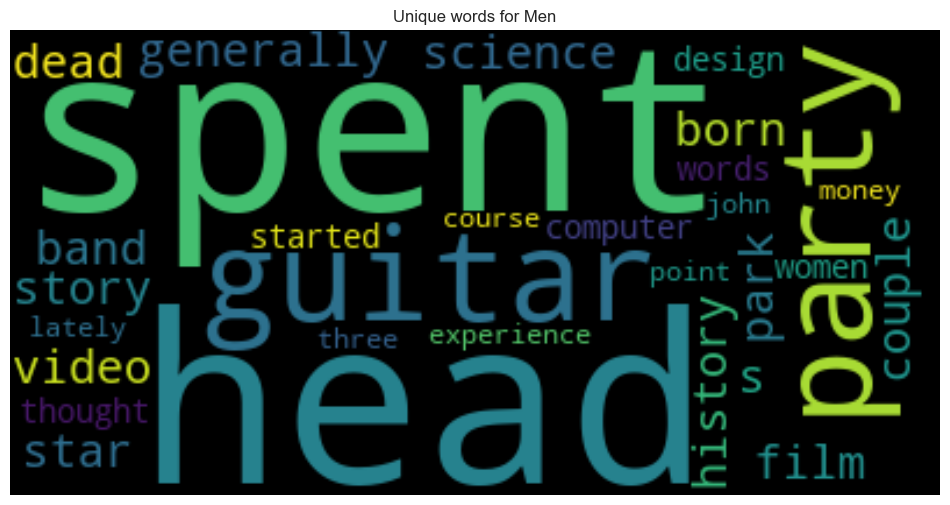

In [255]:
men_wordcloud = WordCloud().generate(' '.join(unique_men))
plt.imshow(men_wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("Unique words for Men")

Text(0.5, 1.0, 'Unique words for Women')

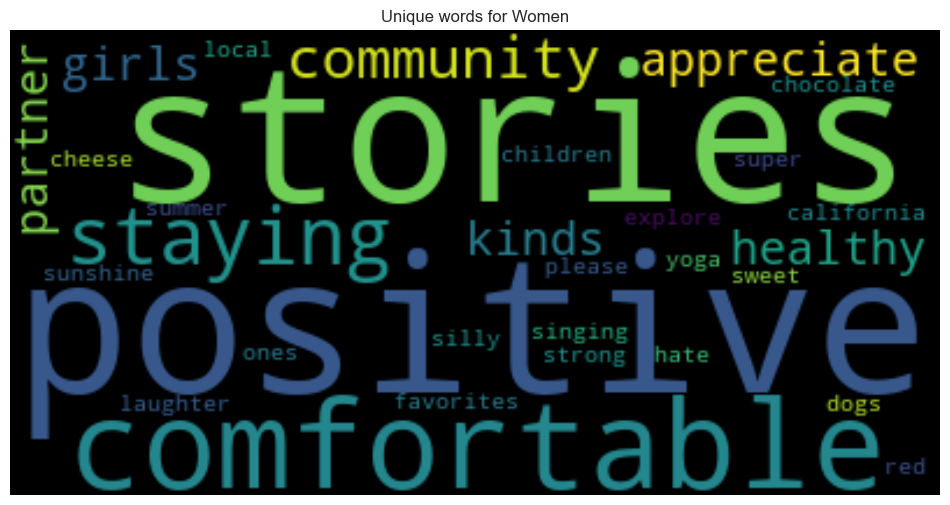

In [256]:
women_wordcloud = WordCloud().generate(' '.join(unique_women))
plt.imshow(women_wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("Unique words for Women")

## 3.2. Comparison of essay between high school dropouts and Ph.D graduates

An interesting comparison that could also be made is with space camp graduates vs college graduates

In [257]:
high_school_drop = data[data.education == 'dropped out of high school']
all_dropout_essays = []

for i in range(10):
    for essay in high_school_drop[f'essay{i}']:
        all_dropout_essays.append(essay)
    
all_dropout_essays = [x for x in all_dropout_essays if str(x) != 'nan']
all_dropout_essays = ' '.join(all_dropout_essays)

phd_grads = data[data.education == 'graduated from ph.d program']
all_phd_essays = []

for i in range(10):
    for essay in phd_grads[f'essay{i}']:
        all_phd_essays.append(essay)
    
all_phd_essays = [x for x in all_phd_essays if str(x) != 'nan']
all_phd_essays = ' '.join(all_phd_essays)

In [258]:
all_dropout_words = all_dropout_essays.split()
dropout_freq = nltk.FreqDist(all_dropout_words)
dropout_freq = dropout_freq.most_common(500)

all_phd_words = all_phd_essays.split()
phd_freq = nltk.FreqDist(all_phd_words)
phd_freq = phd_freq.most_common(500)

dropout = pd.DataFrame(dropout_freq)[0]
phd = pd.DataFrame(phd_freq)[0]

unique_dropout = list(set(dropout) - set(phd))
unique_phd = list(set(phd) - set(dropout))

unique_df = pd.concat([pd.DataFrame(unique_dropout), pd.DataFrame(unique_phd)], axis=1)
unique_df.columns = ['unique_dropout', 'unique_phd']
unique_df.head(15)

,unique_dropout,unique_phd
0,hell,interests
1,drinking,spent
2,type,fit
3,head,warm
4,lisa,generally
5,yeah,intelligent
6,fight,hope
7,girls,research
8,above,didn't
9,horror,*


Text(0.5, 1.0, 'Unique words for High school dropouts')

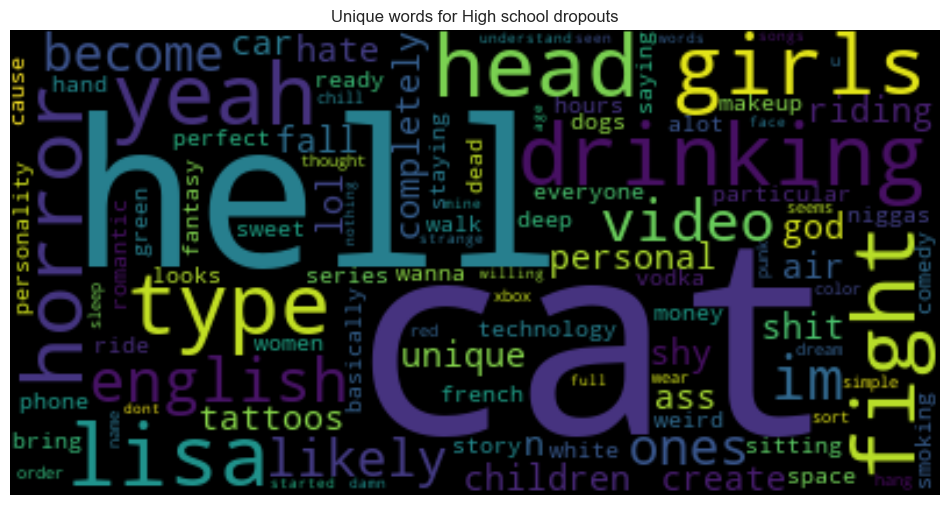

In [259]:
dropout_wordcloud = WordCloud().generate(' '.join(unique_dropout))
plt.imshow(dropout_wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("Unique words for High school dropouts")

Text(0.5, 1.0, 'Unique words for Ph.D grads')

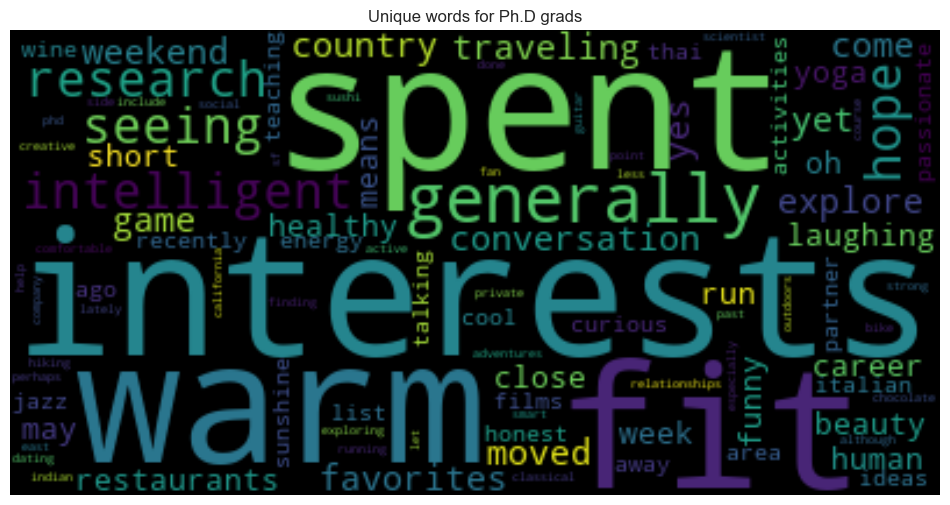

In [260]:
phd_wordcloud = WordCloud().generate(' '.join(unique_phd))
plt.imshow(phd_wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("Unique words for Ph.D grads")

## 3.3. Income Analysis

Look at income based on age

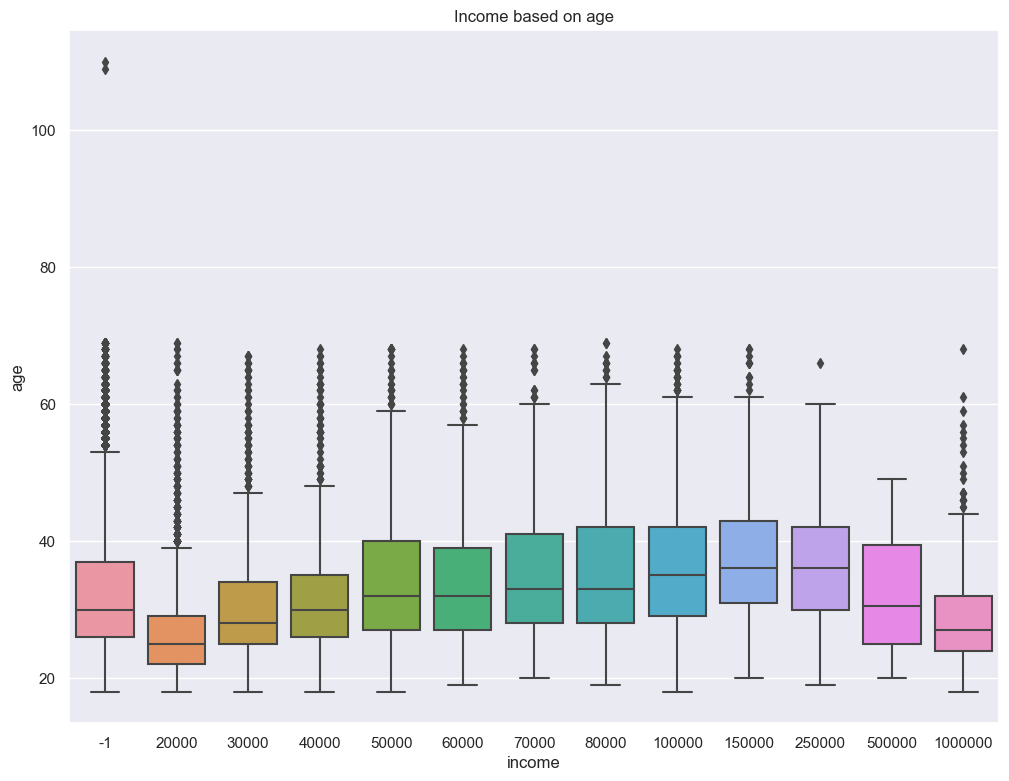

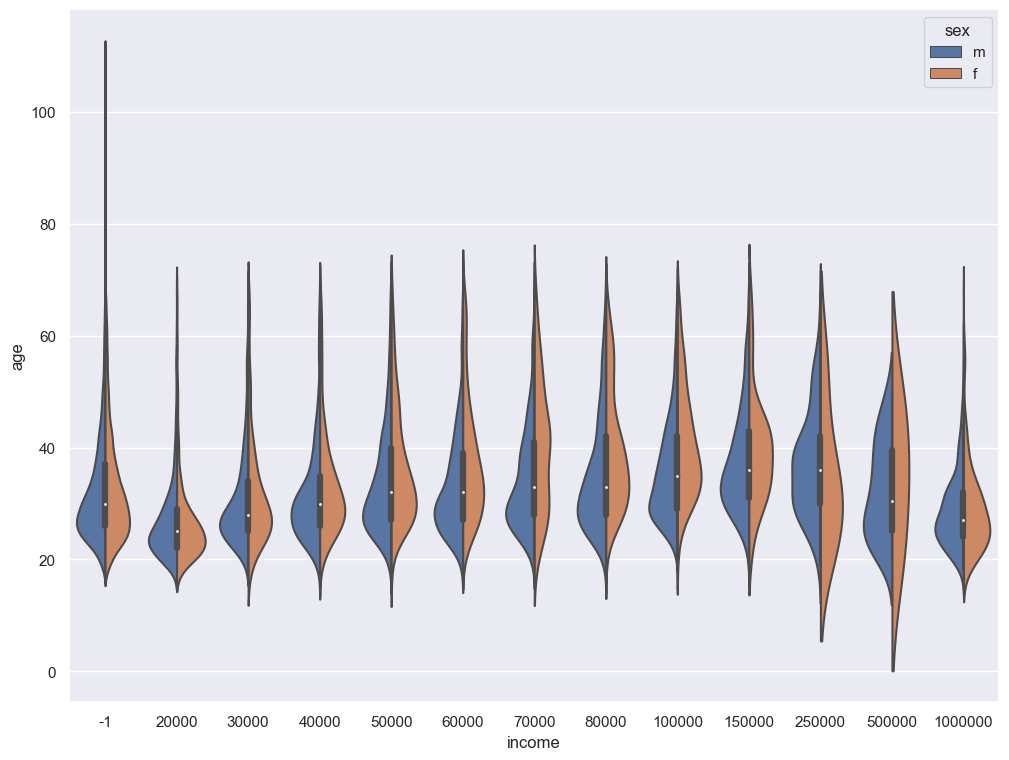

In [261]:
sns.boxplot(data['income'], data['age']).set_title('Income based on age')
plt.show()
sns.violinplot(data=data, x='income', y='age', hue='sex', split=True);

#### Let's test the stereotype that the rich are popular with the opposite sex

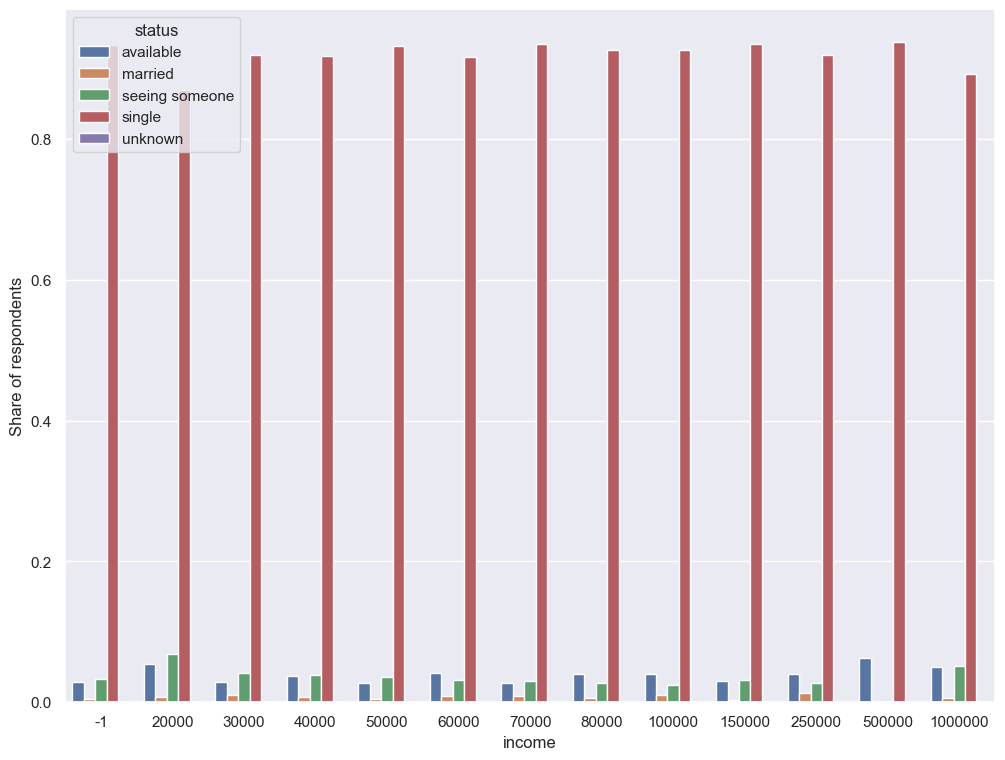

In [262]:
ct = pd.crosstab(data['income'], data['status'], margins=True)
ct = ct[ct.columns[:-1]]/np.tile(ct['All'].values, (5,1)).T

stacked = ct.iloc[:-1].stack().reset_index().rename(columns={0:'Share of respondents'})
sns.barplot(x=stacked['income'], y=stacked['Share of respondents'], hue=stacked['status']);

### 3.3.2. Income of sexual orientation

Another stereotype is that among the rich there are many people of non-traditional sexual orientation. Let's check it out

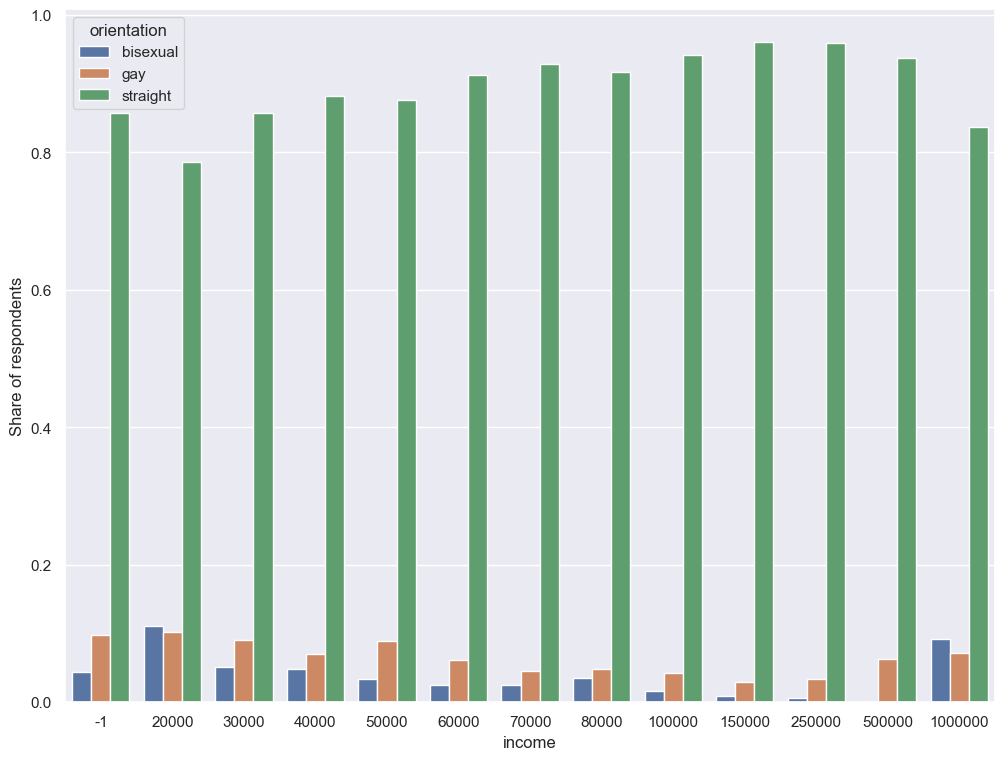

In [263]:
ct = pd.crosstab(data['income'], data['orientation'], margins=True)
ct = ct[ct.columns[:-1]]/np.tile(ct['All'].values, (3,1)).T

stacked = ct.iloc[:-1].stack().reset_index().rename(columns={0:'Share of respondents'})
sns.barplot(x=stacked['income'], y=stacked['Share of respondents'], hue=stacked['orientation']);

The myth is partly confirmed :) nevertheless, there are even more LGBT people among low-income people.

**Income doesn't seem to affect happiness in your personal life at all. What about physique?**

## 3.4. Body Type Analysis

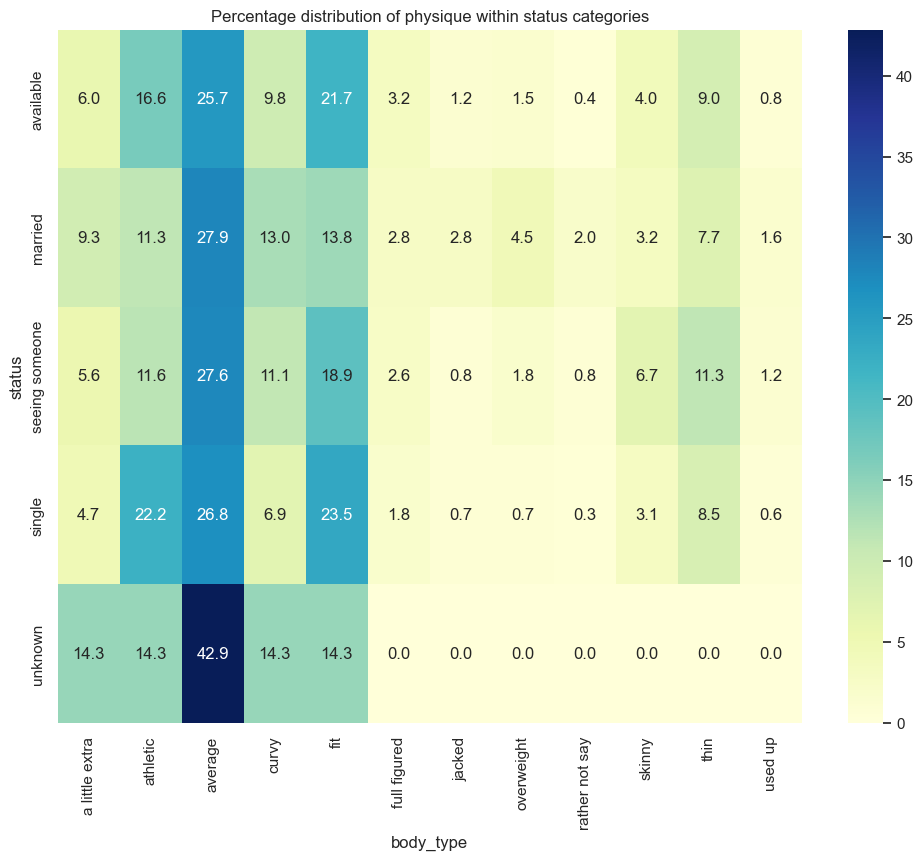

In [264]:
ct = pd.crosstab(data['body_type'], data['status'], margins=True).T
ct = ct[ct.columns[:-1]]/np.tile(ct['All'].values, (12,1)).T*100

sns.heatmap(ct.iloc[:-1], fmt='.1f', annot=True, cmap="YlGnBu").set_title('Percentage distribution of physique within status categories');

As you can see, the majority of respondents are of "average build" :). Those who are married no less follow the maintenance of shape, and among them there is a significantly higher percentage of people who are overweight.

Now let's look at the target feature, its distribution


### 3.4.2 Physique of sexual orientation

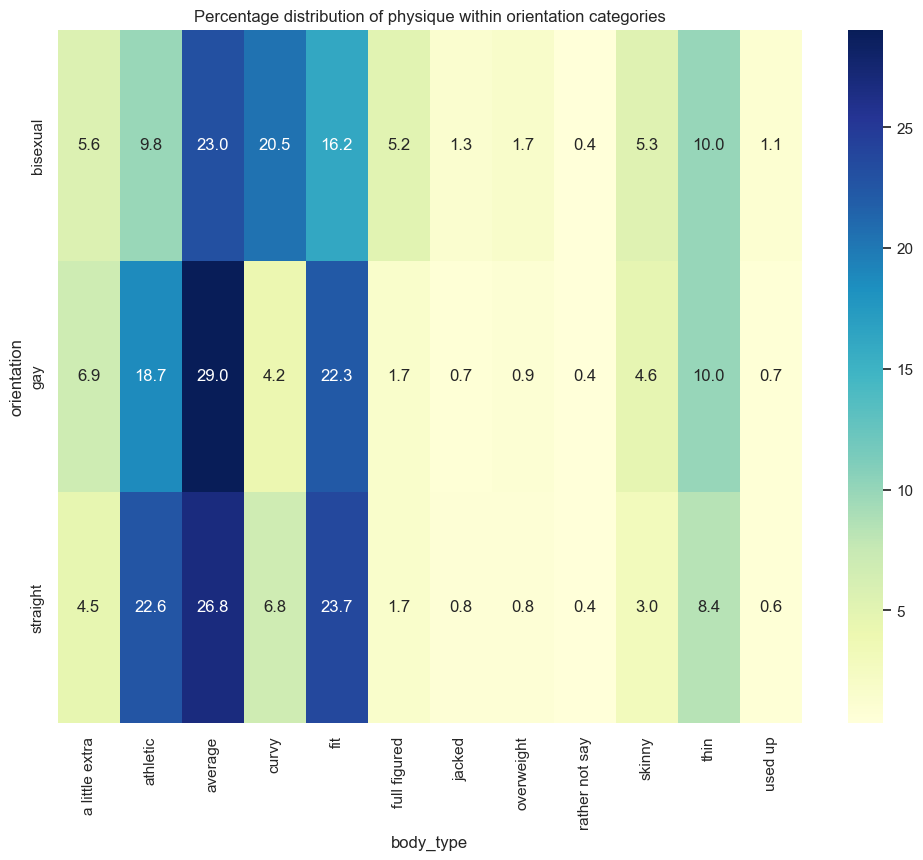

In [265]:
ct = pd.crosstab(data['body_type'], data['orientation'], margins=True).T
ct = ct[ct.columns[:-1]]/np.tile(ct['All'].values, (12,1)).T*100

sns.heatmap(ct.iloc[:-1], fmt='.1f', annot=True, cmap="YlGnBu").set_title('Percentage distribution of physique within orientation categories');

Bisexual respondents seem to be significantly "figurier" of the rest - looks like a good sign. While between gays and heterosexuals - there is not much difference in physique

## 3.5. Orientation Analysis

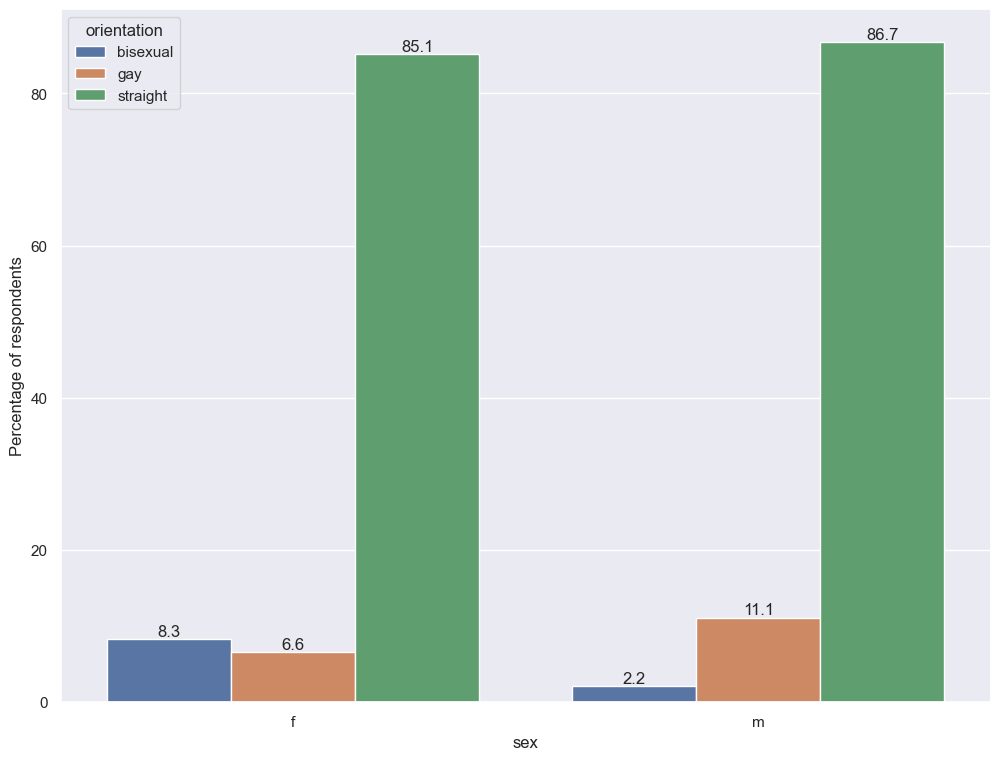

In [266]:
ct = pd.crosstab(data['sex'], data['orientation'], margins=True)
ct = ct[ct.columns[:-1]]/np.tile(ct['All'].values, (3,1)).T*100

fig, ax = plt.subplots(1,1)
stacked = ct.iloc[:-1].stack().reset_index().rename(columns={0:'Percentage of respondents'})
sns.barplot(x=stacked['sex'], y=stacked['Percentage of respondents'], hue=stacked['orientation'], ax=ax);

for p in ax.patches:
  x=p.get_bbox().get_points()[:,0]
  y=p.get_bbox().get_points()[1,1]
  ax.annotate('{0:.1f}'.format(p.get_height()), (x.mean(), y), ha='center', va='bottom');

As you can see, heterosexual men and women are approximately 85% each, but women of non-traditional sexual orientation prefer bisexuality, while men are mostly strictly homosexual.

### 3.5.1. Status of sexual orientation

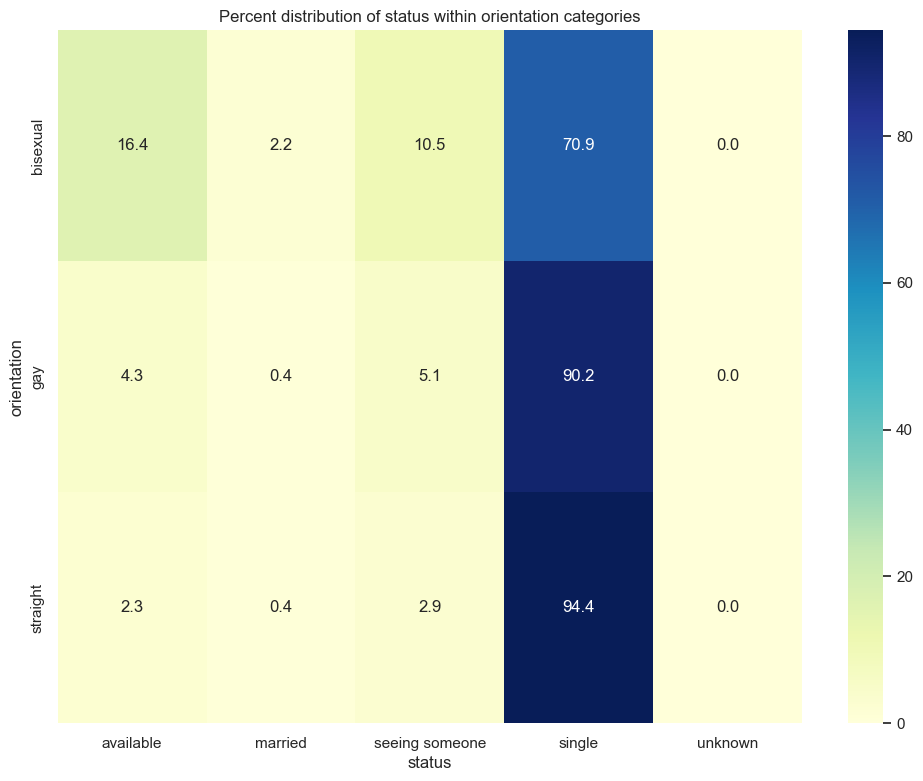

In [267]:
ct = pd.crosstab(data['status'], data['orientation'], margins=True).T
ct = ct[ct.columns[:-1]]/np.tile(ct['All'].values, (5,1)).T*100

sns.heatmap(ct.iloc[:-1], fmt='.1f', annot=True, cmap="YlGnBu").set_title('Percent distribution of status within orientation categories');

Bisexuals are much less likely to be single than others. This is probably due to the nature of bisexuality - there is a motivation to use a dating site even with a partner.

### 3.5.2. Religion VS Sexual Orientation

Some religions ban LGBT people. Let's look at the distribution among religions and among the seriousness of attitudes towards religion

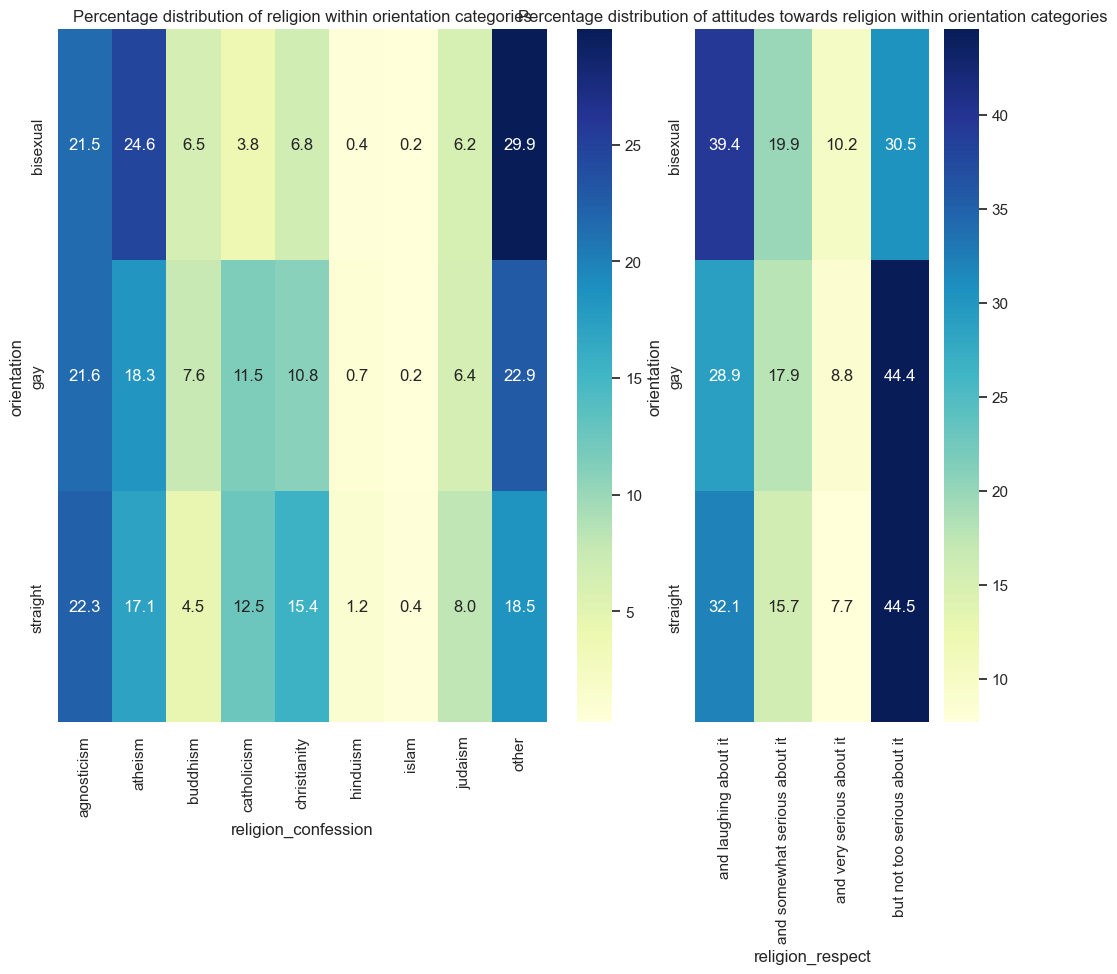

In [268]:
ct = pd.crosstab(data['religion_confession'], data['orientation'], margins=True).T
ct = ct[ct.columns[:-1]]/np.tile(ct['All'].values, (9,1)).T*100

ax1 = plt.subplot2grid((1,6),(0,0), colspan=4)

sns.heatmap(ct.iloc[:-1], fmt='.1f', annot=True, cmap="YlGnBu", ax=ax1) \
.set_title('Percentage distribution of religion within orientation categories');

ax2 = plt.subplot2grid((1,6),(0,4), colspan=2, sharey=ax1)
ct = pd.crosstab(data['religion_respect'], data['orientation'], margins=True).T
ct = ct[ct.columns[:-1]]/np.tile(ct['All'].values, (4,1)).T*100

sns.heatmap(ct.iloc[:-1], fmt='.1f', annot=True, cmap="YlGnBu", ax=ax2) \
.set_title('Percentage distribution of attitudes towards religion within orientation categories');

Among atheists, and those who find the topic of religion funny, there are significantly more bisexuals. LGBT people have significantly fewer representatives of Abrahamic religions, apparently the church has its own influence. Among gays, this trend is not observed as strongly as among bi. Unfortunately gays don't really stand out :(

### 3.5.3. Bad Habits VS Sexual Orientation

We look at attitudes towards drugs and alcohol, cigarettes and diets

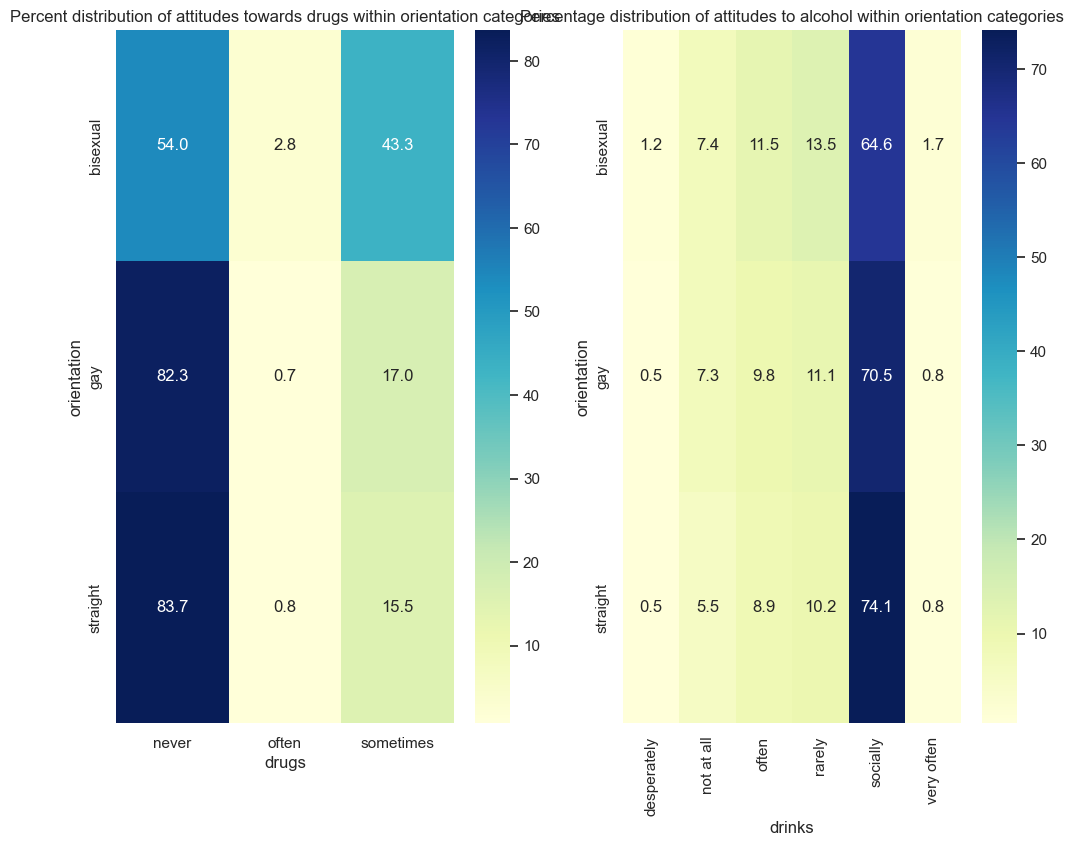

In [269]:
f, (ax1, ax2) = plt.subplots(1, 2)
ct = pd.crosstab(data['drugs'], data['orientation'], margins=True).T
ct = ct[ct.columns[:-1]]/np.tile(ct['All'].values, (3,1)).T*100
sns.heatmap(ct.iloc[:-1], fmt='.1f', annot=True, cmap="YlGnBu", ax=ax1) \
.set_title('Percent distribution of attitudes towards drugs within orientation categories');

ct = pd.crosstab(data['drinks'], data['orientation'], margins=True).T
ct = ct[ct.columns[:-1]]/np.tile(ct['All'].values, (6,1)).T*100
sns.heatmap(ct.iloc[:-1], fmt='.1f', annot=True, cmap="YlGnBu", ax=ax2) \
.set_title('Percentage distribution of attitudes to alcohol within orientation categories');


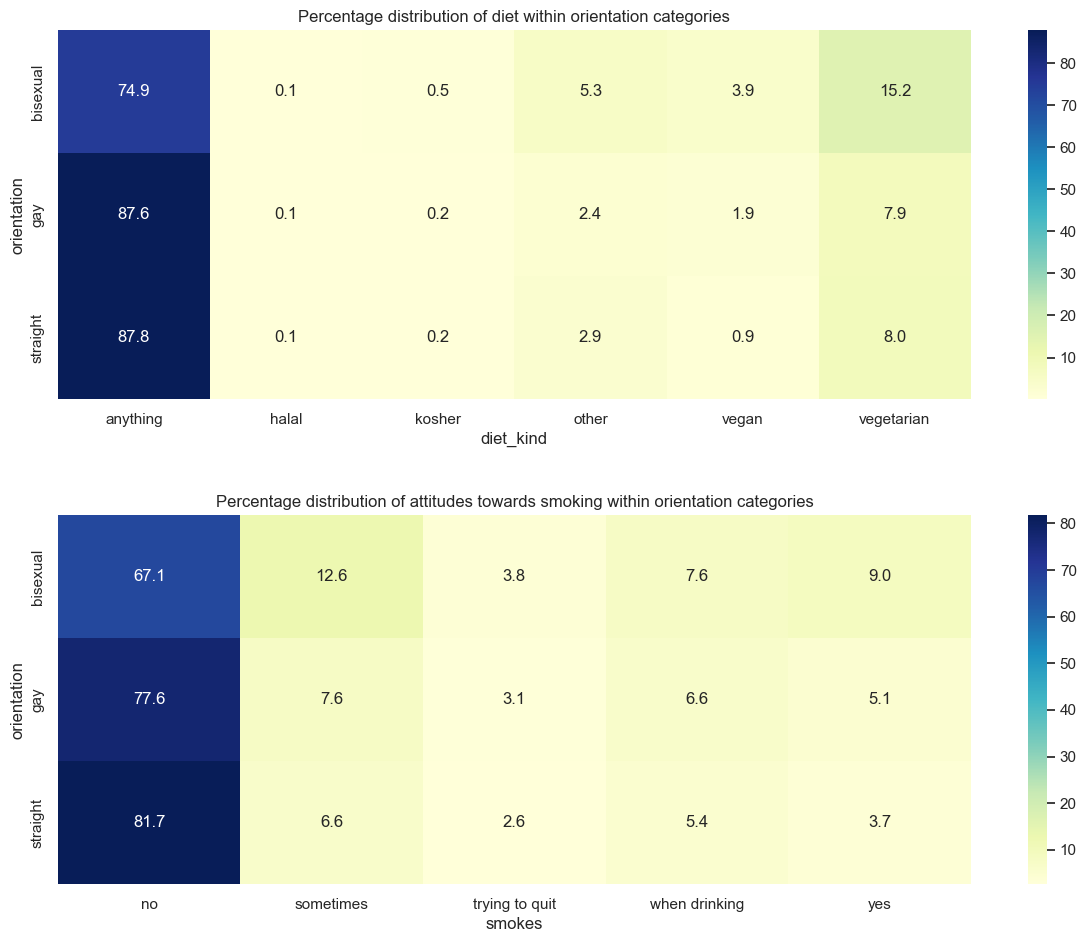

In [270]:
f, (ax1, ax2) = plt.subplots(2, 1)
plt.tight_layout(pad=0.4, w_pad=4.5, h_pad=5)

ct = pd.crosstab(data['diet_kind'], data['orientation'], margins=True).T
ct = ct[ct.columns[:-1]]/np.tile(ct['All'].values, (6,1)).T*100
sns.heatmap(ct.iloc[:-1], fmt='.1f', annot=True, cmap="YlGnBu", ax=ax1) \
.set_title('Percentage distribution of diet within orientation categories');

ct = pd.crosstab(data['smokes'], data['orientation'], margins=True).T
ct = ct[ct.columns[:-1]]/np.tile(ct['All'].values, (5,1)).T*100
sns.heatmap(ct.iloc[:-1], fmt='.1f', annot=True, cmap="YlGnBu", ax=ax2) \
.set_title('Percentage distribution of attitudes towards smoking within orientation categories');

Well, it is clear that bisexuals have a tolerant attitude towards drugs, smoke more and limit themselves to diets. It seems that there is no particular difference in the signs for gays, it is just that the correlation is weaker on them.

### 3.5.4. Astrology VS Sexual Orientation

Let's try to look for a correlation among the signs - let's check how the orientation is distributed among different zodiac signs and attitudes towards astrology :)

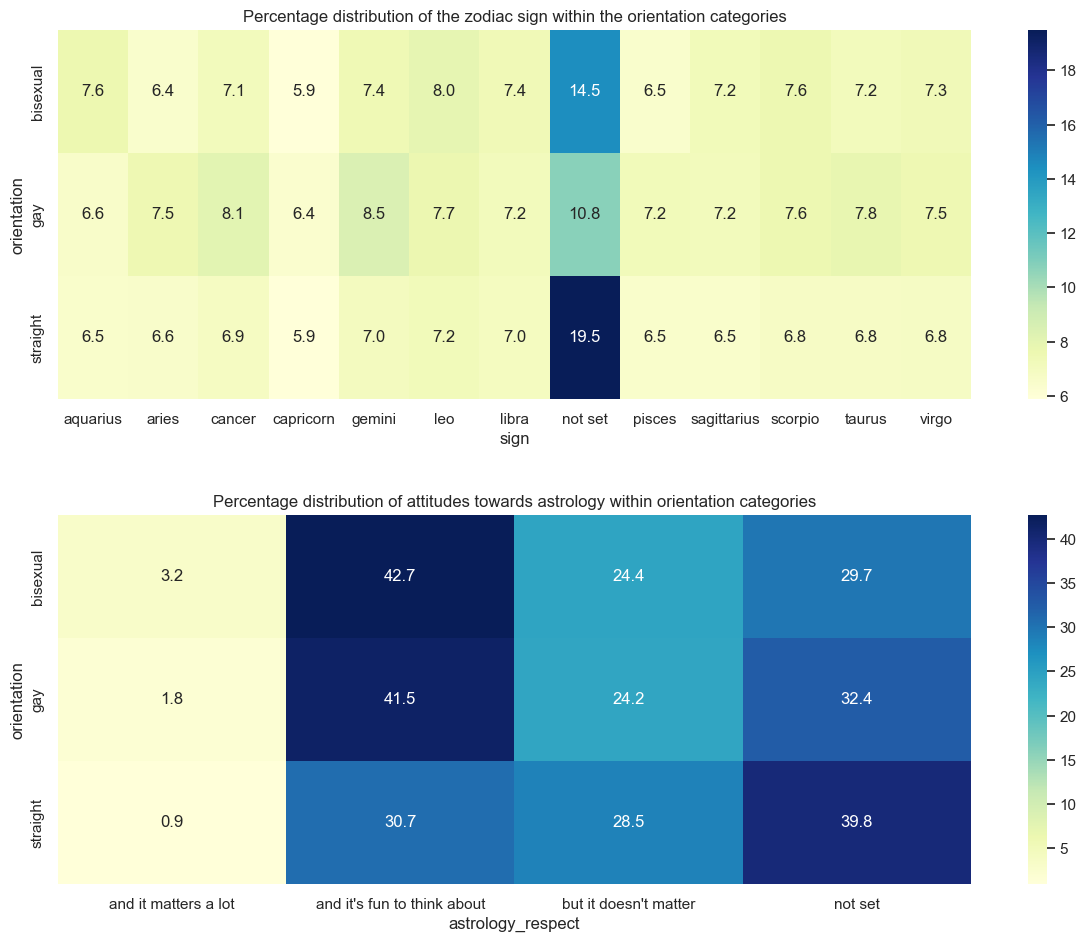

In [271]:
f, (ax1, ax2) = plt.subplots(2, 1)
plt.tight_layout(pad=0.4, w_pad=4.5, h_pad=5)

ct = pd.crosstab(data['sign'], data['orientation'], margins=True).T
ct = ct[ct.columns[:-1]]/np.tile(ct['All'].values, (13,1)).T*100
sns.heatmap(ct.iloc[:-1], fmt='.1f', annot=True, cmap="YlGnBu", ax=ax1) \
.set_title('Percentage distribution of the zodiac sign within the orientation categories');

data['astrology_respect'] = data['astrology_respect'].str.replace('&rsquo;',"'")

ct = pd.crosstab(data['astrology_respect'], data['orientation'], margins=True).T
ct = ct[ct.columns[:-1]]/np.tile(ct['All'].values, (4,1)).T*100
sns.heatmap(ct.iloc[:-1], fmt='.1f', annot=True, cmap="YlGnBu", ax=ax2) \
.set_title('Percentage distribution of attitudes towards astrology within orientation categories');

Finally, homosexuals have distinguished themselves from bi - they are much less likely to leave the zodiac sign field empty :) And if you are cancer or gemini, then you have a higher chance of being gay. I do not want to offend astrology lovers, but it seems to me that in fact, the dependence of orientation on the zodiac sign is absolutely zero, and we are dealing with a false correlation